Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Starting main execution...

Loading datasets...
Successfully loaded both datasets
Datasets loaded successfully

Generating enhanced features...

Starting feature generation...
Network nodes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']

Generating base features...

Initial DataFrame shape: (1000, 8)
Initial columns: ['time', 'pdr', 'vehicle_density', 'average_speed', 'network_congestion', 'source_location', 'destination_location', 'optimal_protocol']

Calculating route metrics...

Applying protocol selection rules...

Final DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   time                  1000 non-null   float64
 1   pdr                   1000 non-null   float64
 2   vehicle_d

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.4897 - loss: 0.9893 - val_accuracy: 0.7150 - val_loss: 0.6255
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6970 - loss: 0.6744 - val_accuracy: 0.8100 - val_loss: 0.5566
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7789 - loss: 0.5514 - val_accuracy: 0.8150 - val_loss: 0.4960
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8429 - loss: 0.4518 - val_accuracy: 0.8600 - val_loss: 0.4388
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8789 - loss: 0.3825 - val_accuracy: 0.8450 - val_loss: 0.4118
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8578 - loss: 0.3584 - val_accuracy: 0.8600 - val_loss: 0.3630
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8598 - loss: 0.3330 - val_accuracy: 0.8750 - val_loss: 0.3205
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8964 - loss: 0.2970 - val_accuracy: 0.8950 - val_loss: 0.2921
Ep

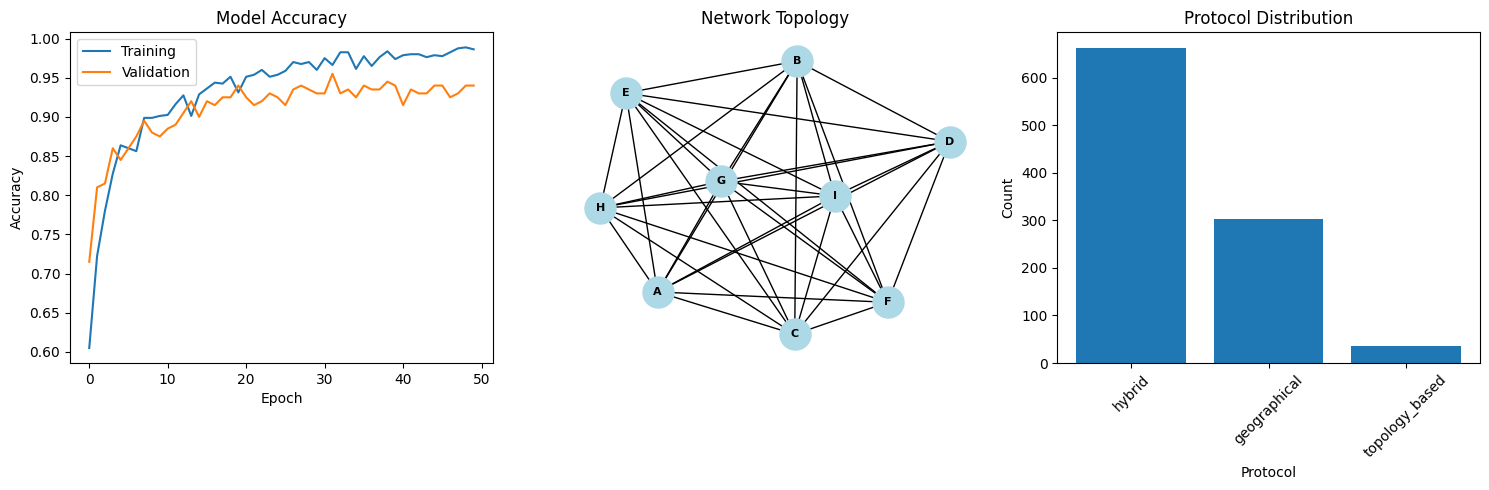

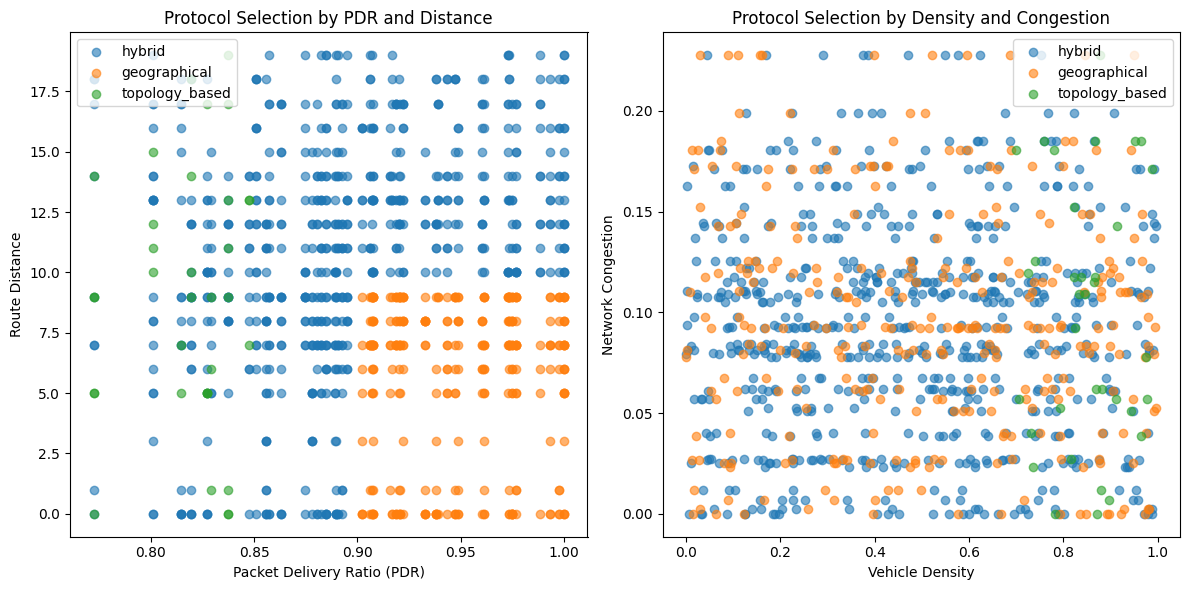


Testing with sample scenarios...

Error occurred: "'optimal_protocol' column not found in the dataset"

Full error details:


Traceback (most recent call last):
  File "<ipython-input-9-24d1451fc848>", line 335, in <cell line: 333>
    main()
  File "<ipython-input-9-24d1451fc848>", line 305, in main
    predictions = routing_system.predict_protocol(sample_scenarios)
  File "<ipython-input-9-24d1451fc848>", line 193, in predict_protocol
    processed_features = self.prepare_data(features)[0]
  File "<ipython-input-9-24d1451fc848>", line 142, in prepare_data
    raise KeyError("'optimal_protocol' column not found in the dataset")
KeyError: "'optimal_protocol' column not found in the dataset"


In [9]:
# Import required libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from google.colab import drive
import os

drive.mount('/content/drive')

def load_datasets():
    try:
        # Update these paths according to your Google Drive structure
        pdr_data = pd.read_csv('/content/drive/My Drive/pdr_vs_time_dataset.csv')
        routing_data = pd.read_csv('/content/drive/My Drive/Vehicle Routing Dataset.csv')
        print("Successfully loaded both datasets")
        return pdr_data, routing_data
    except Exception as e:
        print(f"Error loading datasets: {e}")
        raise

# Create network graph from routing data
def create_network_graph(routing_data):
    G = nx.Graph()
    locations = routing_data['Location'].values
    notations = routing_data['Notation'].values

    # Add nodes
    for loc, note in zip(locations, notations):
        G.add_node(note, location=loc)

    # Add edges with distances
    for i, row in routing_data.iterrows():
        source = row['Notation']
        for dest in routing_data['Notation']:
            if dest != source:
                dist_col = f'Distance from {dest}'
                if dist_col in row.index:
                    distance = row[dist_col]
                    G.add_edge(source, dest, weight=distance)
    return G

# Generate enhanced features using both datasets
def generate_enhanced_features(pdr_data, routing_data, n_samples=1000):
    print("\nStarting feature generation...")
    G = create_network_graph(routing_data)
    nodes = list(G.nodes())
    print(f"Network nodes: {nodes}")

    print("\nGenerating base features...")
    np.random.seed(42)
    base_data = {
        'time': np.random.choice(pdr_data['Time (s)'].values, n_samples),
        'pdr': np.random.choice(pdr_data['PDR'].values, n_samples),
        'vehicle_density': np.random.uniform(0, 1, n_samples),
        'average_speed': np.random.uniform(0, 120, n_samples),
        'network_congestion': 1 - np.random.choice(pdr_data['PDR'].values, n_samples),
        'source_location': np.random.choice(nodes, n_samples),
        'destination_location': np.random.choice(nodes, n_samples),
        'optimal_protocol': ['hybrid'] * n_samples  # Initialize with default value
    }

    # Create DataFrame
    df = pd.DataFrame(base_data)
    print("\nInitial DataFrame shape:", df.shape)
    print("Initial columns:", df.columns.tolist())

    print("\nCalculating route metrics...")
    # Calculate route metrics
    route_distances = []
    route_hops = []

    for src, dest in zip(df['source_location'], df['destination_location']):
        try:
            if src != dest:
                distance = float(nx.shortest_path_length(G, source=src, target=dest, weight='weight'))
                hops = len(nx.shortest_path(G, source=src, target=dest)) - 1
            else:
                distance = 0.0
                hops = 0
        except (nx.NetworkXNoPath, nx.NodeNotFound):
            distance = 0.0
            hops = 0
        route_distances.append(distance)
        route_hops.append(hops)

    df['route_distance'] = route_distances
    df['route_hops'] = route_hops

    print("\nApplying protocol selection rules...")
    # Update protocols based on conditions
    conditions = [
        (df['route_distance'] < 10.0) & (df['pdr'] > 0.9),
        (df['vehicle_density'] > 0.7) & (df['pdr'] < 0.85),
        (df['route_distance'] > 15.0) & (df['network_congestion'] > 0.3)
    ]
    choices = ['geographical', 'topology_based', 'hybrid']

    df['optimal_protocol'] = np.select(conditions, choices, default='hybrid')

    print("\nFinal DataFrame info:")
    print(df.info())
    print("\nProtocol distribution:")
    print(df['optimal_protocol'].value_counts())

    # Verify the optimal_protocol column exists and has proper values
    assert 'optimal_protocol' in df.columns, "optimal_protocol column is missing"
    assert not df['optimal_protocol'].isnull().any(), "Found null values in optimal_protocol"

    return df
class VANETRoutingSystem:
    def __init__(self):
        self.model = None
        self.scaler = StandardScaler()
        self.protocol_map = {'topology_based': 0, 'geographical': 1, 'hybrid': 2}

    def build_model(self, input_shape):
        model = Sequential([
            Dense(128, activation='relu', input_shape=input_shape),
            Dropout(0.3),
            Dense(64, activation='relu'),
            Dropout(0.2),
            Dense(32, activation='relu'),
            Dense(3, activation='softmax')
        ])

        model.compile(optimizer='adam',
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])
        self.model = model

    def prepare_data(self, data):
        # Ensure optimal_protocol column exists
        if 'optimal_protocol' not in data.columns:
            raise KeyError("'optimal_protocol' column not found in the dataset")

        # Convert protocols to numeric values
        y = data['optimal_protocol'].map(self.protocol_map)

        # Verify all protocols were mapped
        if y.isnull().any():
            invalid_protocols = data.loc[y.isnull(), 'optimal_protocol'].unique()
            raise ValueError(f"Invalid protocol values found: {invalid_protocols}")

        # Convert locations to one-hot encoding
        location_data = pd.get_dummies(data[['source_location', 'destination_location']],
                                     prefix=['source', 'dest'])

        # Select numerical features
        numerical_features = ['time', 'pdr', 'vehicle_density', 'average_speed',
                            'network_congestion', 'route_distance', 'route_hops']
        X_numerical = data[numerical_features]

        # Combine features
        X = pd.concat([X_numerical, location_data], axis=1)

        return X, y

    def train(self, data, epochs=50, batch_size=32):
        print("Preparing data for training...")
        X, y = self.prepare_data(data)

        print("Splitting data into train and test sets...")
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        print("Scaling features...")
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)

        print("Building and training model...")
        self.build_model(input_shape=(X_train.shape[1],))

        history = self.model.fit(X_train_scaled, y_train,
                               validation_data=(X_test_scaled, y_test),
                               epochs=epochs,
                               batch_size=batch_size,
                               verbose=1)

        # Evaluate model
        test_loss, test_accuracy = self.model.evaluate(X_test_scaled, y_test, verbose=0)
        print(f"\nTest accuracy: {test_accuracy:.4f}")

        return history, (X_test_scaled, y_test)

    def predict_protocol(self, features):
        processed_features = self.prepare_data(features)[0]
        features_scaled = self.scaler.transform(processed_features)
        predictions = self.model.predict(features_scaled)
        reverse_map = {v: k for k, v in self.protocol_map.items()}
        return [reverse_map[np.argmax(pred)] for pred in predictions]

def main():
    print("Starting main execution...")
    # Load datasets
    print("\nLoading datasets...")
    pdr_data, routing_data = load_datasets()
    print("Datasets loaded successfully")

    # Generate enhanced dataset
    print("\nGenerating enhanced features...")
    enhanced_data = generate_enhanced_features(pdr_data, routing_data, n_samples=1000)
    print("\nEnhanced features generated successfully")

    # Verify data before model training
    print("\nVerifying enhanced dataset...")
    print("Shape:", enhanced_data.shape)
    print("Columns:", enhanced_data.columns.tolist())
    print("Protocol values:", enhanced_data['optimal_protocol'].unique())

    # Create and train model
    print("\nInitializing routing system...")
    routing_system = VANETRoutingSystem()

    print("\nStarting model training...")
    history, test_data = routing_system.train(enhanced_data, epochs=50)

    # Rest of the visualization code remains the same...

# Add this to the end of the main() function after model training:

    # Visualize results
    print("\nCreating visualizations...")
    plt.figure(figsize=(15, 5))

    # Plot 1: Training History
    plt.subplot(1, 3, 1)
    plt.plot(history.history['accuracy'], label='Training')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot 2: Network Topology
    plt.subplot(1, 3, 2)
    G = create_network_graph(routing_data)
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_color='lightblue',
            node_size=500, font_size=8, font_weight='bold')
    plt.title('Network Topology')

    # Plot 3: Protocol Distribution
    plt.subplot(1, 3, 3)
    protocol_counts = enhanced_data['optimal_protocol'].value_counts()
    plt.bar(protocol_counts.index, protocol_counts.values)
    plt.title('Protocol Distribution')
    plt.xlabel('Protocol')
    plt.ylabel('Count')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

    # Additional performance visualization
    plt.figure(figsize=(12, 6))

    # Plot 4: PDR vs Protocol Selection
    plt.subplot(1, 2, 1)
    for protocol in enhanced_data['optimal_protocol'].unique():
        mask = enhanced_data['optimal_protocol'] == protocol
        plt.scatter(enhanced_data[mask]['pdr'],
                   enhanced_data[mask]['route_distance'],
                   label=protocol, alpha=0.6)
    plt.xlabel('Packet Delivery Ratio (PDR)')
    plt.ylabel('Route Distance')
    plt.title('Protocol Selection by PDR and Distance')
    plt.legend()

    # Plot 5: Vehicle Density vs Network Congestion
    plt.subplot(1, 2, 2)
    for protocol in enhanced_data['optimal_protocol'].unique():
        mask = enhanced_data['optimal_protocol'] == protocol
        plt.scatter(enhanced_data[mask]['vehicle_density'],
                   enhanced_data[mask]['network_congestion'],
                   label=protocol, alpha=0.6)
    plt.xlabel('Vehicle Density')
    plt.ylabel('Network Congestion')
    plt.title('Protocol Selection by Density and Congestion')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Test scenarios and predictions
    print("\nTesting with sample scenarios...")
    sample_scenarios = pd.DataFrame({
        'time': [0, 20, 40, 60],
        'pdr': [0.95, 0.85, 0.75, 0.90],
        'vehicle_density': [0.8, 0.2, 0.5, 0.9],
        'average_speed': [25, 70, 45, 15],
        'network_congestion': [0.3, 0.4, 0.9, 0.2],
        'source_location': ['A', 'B', 'C', 'D'],
        'destination_location': ['E', 'F', 'G', 'H'],
        'route_distance': [8, 8, 16, 12],
        'route_hops': [2, 2, 3, 2]
    })

    predictions = routing_system.predict_protocol(sample_scenarios)

    # Create a visualization of predictions
    plt.figure(figsize=(10, 6))
    colors = {'topology_based': 'red', 'geographical': 'blue', 'hybrid': 'green'}
    for i, pred in enumerate(predictions):
        plt.scatter(sample_scenarios['vehicle_density'][i],
                   sample_scenarios['pdr'][i],
                   color=colors[pred],
                   s=100,
                   label=f'Scenario {i+1}: {pred}')
    plt.xlabel('Vehicle Density')
    plt.ylabel('PDR')
    plt.title('Protocol Predictions for Test Scenarios')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # Print detailed results
    print("\nSample Scenario Predictions:")
    for i, pred in enumerate(predictions):
        print(f"\nScenario {i+1}:")
        print(f"Route: {sample_scenarios['source_location'][i]} -> {sample_scenarios['destination_location'][i]}")
        print(f"Distance: {sample_scenarios['route_distance'][i]} km")
        print(f"PDR: {sample_scenarios['pdr'][i]:.3f}")
        print(f"Vehicle Density: {sample_scenarios['vehicle_density'][i]:.2f}")
        print(f"Network Congestion: {sample_scenarios['network_congestion'][i]:.2f}")
        print(f"Predicted Protocol: {pred}")
if __name__ == "__main__":
    try:
        main()
    except Exception as e:
        print(f"\nError occurred: {str(e)}")
        print("\nFull error details:")
        import traceback
        traceback.print_exc()